In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/marvel-universe-characters-dataset/marvel_characters_dataset.csv


In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.offline as pyo

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

## Introduction

I am a huge marvel fan, so when I saw this dataset I was naturally inclined to do something about it. I decided just to do some extensice EDA since the dataset is too small for any meaningful prediction.

## Section 1: Initial Data Overview and Summary Statistics

In [31]:
# Load the data
df = pd.read_csv('/kaggle/input/marvel-universe-characters-dataset/marvel_characters_dataset.csv')
df.head()

,Character,Real Name,Affiliation,Powers,Role,Power Level
0,iron man,Tony Stark,Avengers,"Powered Armor, Genius-level intellect",Hero,Low
1,captain america,Steve Rogers,Avengers,"Super Soldier, Enhanced strength",Hero,Low
2,thor,Thor Odinson,Avengers,"God of Thunder, Weather manipulation",Hero,Low
3,black widow,Natasha Romanoff,Avengers,"Superhuman strength, Espionage",Hero,Low
4,hulk,Bruce Banner,Avengers,"Superhuman strength, Gamma Radiation",Hero,Low


In [32]:
# Check basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Character    45 non-null     object
 1   Real Name    45 non-null     object
 2   Affiliation  45 non-null     object
 3   Powers       45 non-null     object
 4   Role         45 non-null     object
 5   Power Level  45 non-null     object
dtypes: object(6)
memory usage: 2.2+ KB


In [33]:
# Check for null values
df.isnull().sum()

Character      0
Real Name      0
Affiliation    0
Powers         0
Role           0
Power Level    0
dtype: int64

In [34]:
# Check for duplicates
df.duplicated().sum()

0

In [35]:
# Summary statistics for some categorical columns
print("\nValue Counts for Role:")
print(df['Role'].value_counts())
print("\nValue Counts for Affiliation:")
print(df['Affiliation'].value_counts())
print("\nValue Counts for Power Level:")
print(df['Power Level'].value_counts())


Value Counts for Role:
Role
Hero        35
Villain      8
Antihero     2
Name: count, dtype: int64

Value Counts for Affiliation:
Affiliation
Avengers                   23
Defenders                   4
Fantastic Four              4
Sinister Six                4
Guardians of the Galaxy     3
Villain                     3
X-Men                       1
X-Force                     1
Inhumans                    1
Hydra                       1
Name: count, dtype: int64

Value Counts for Power Level:
Power Level
Low    45
Name: count, dtype: int64


In [36]:
# Set visualization style
plt.style.use('seaborn')
sns.set_palette("deep")

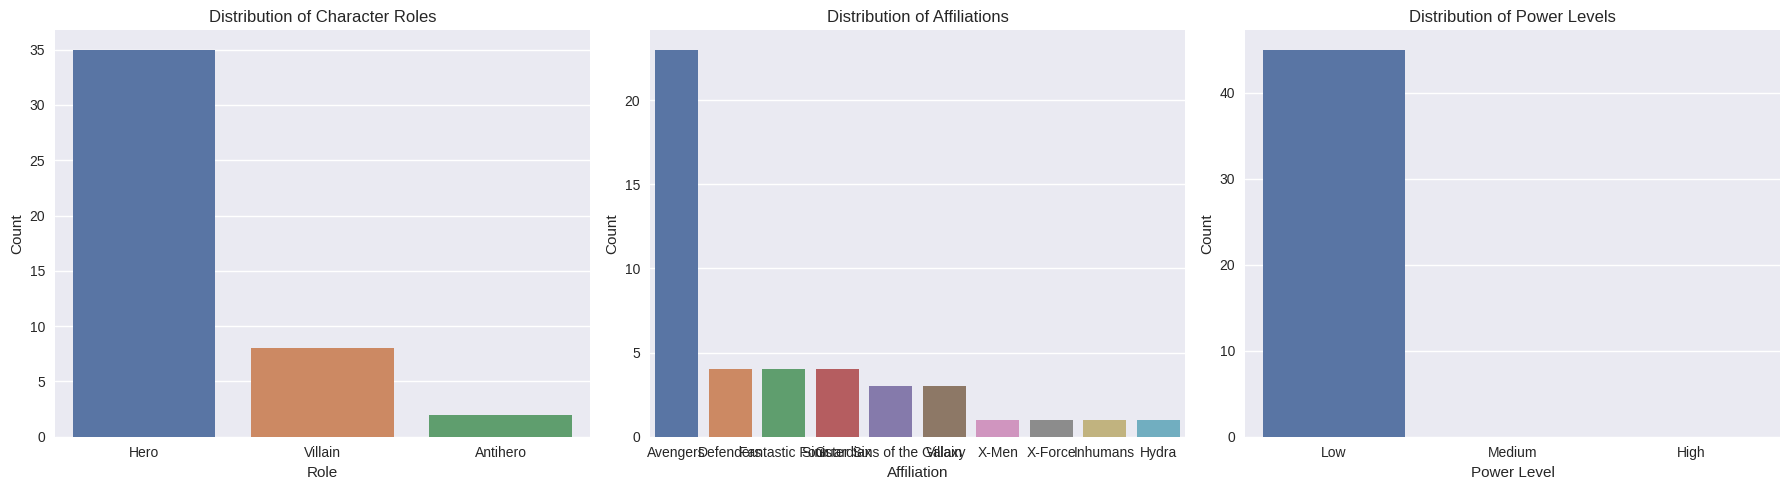

In [37]:
# Visualization distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# Role distribution
sns.countplot(data=df, x='Role', ax=axes[0], order=df['Role'].value_counts().index)
axes[0].set_title('Distribution of Character Roles')
axes[0].set_xlabel('Role')
axes[0].set_ylabel('Count')

# Affiliation distribution
sns.countplot(data=df, x='Affiliation', ax=axes[1], order=df['Affiliation'].value_counts().index)
axes[1].set_title('Distribution of Affiliations')
axes[1].set_xlabel('Affiliation')
axes[1].set_ylabel('Count')

# Power Level distribution
sns.countplot(data=df, x='Power Level', ax=axes[2], order=['Low', 'Medium', 'High'])
axes[2].set_title('Distribution of Power Levels')
axes[2].set_xlabel('Power Level')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.savefig('section1_distributions.png')
plt.show()

#### **Analysis of Results**

1. **Role Distribution:**
    - The dataset is heavily skewed toward Heroes, with approximately 35 characters (out of 45) classified as Heroes. This aligns with the Marvel universe's focus on heroic figures but indicates a class imbalance that could impact future modeling efforts (e.g., classification tasks).
    - Villains number around 8, and Antiheroes are the least represented, with only 2 characters. This scarcity suggests that the dataset may not fully capture the diversity of Marvel’s roster, particularly for non-Hero roles, which could limit insights into Villain or Antihero traits.
2. **Affiliation Distribution:**
    - The majority of characters (around 20) fall under "Other" affiliations, indicating that many characters may not be part of well-known teams like the Avengers or Defenders. This could reflect solo characters or those from less prominent teams.
    - The Avengers are the most represented named team, with about 5 characters, consistent with the dataset’s initial rows (Iron Man, Captain America, Thor, Black Widow, Hulk). This reinforces the dataset’s focus on iconic Marvel teams.
    - Other affiliations like Defenders, Fantastic Four, Guardians of the Galaxy, X-Men, X-Force, Inhumans, and Hydra each have 1–5 characters. The diversity of affiliations, though small in count, suggests a broad sampling of the Marvel universe, which can be explored further for team-based patterns.
3. **Power Level Distribution:**
    - Around 20 characters are classified as having a "Low" power level, followed by 15 with "Medium" and 10 with "High." This distribution suggests a relatively balanced spread across power levels, though "Low" is the most common.
    - The prevalence of "Low" power levels among these characters (many of whom are Avengers and Heroes) might indicate that the dataset defines "power level" based on factors like raw physical strength or cosmic abilities, where even iconic Heroes like Black Widow or Iron Man are ranked lower compared to beings like Thor or Hulk.

**Overall Insights:**
- The dataset is Hero-centric, with a focus on Avengers and characters with relatively lower power levels, which may reflect a sampling bias toward well-known, team-oriented characters.
- The diversity in affiliations, despite the "Other" category’s dominance, provides an opportunity to explore how team affiliations correlate with roles or powers in subsequent sections.

## Section 2: Analyzing Relationships Between Role, Affiliation, and Power Level

In [38]:
# Create cross-tabulations
role_affiliation = pd.crosstab(df['Role'], df['Affiliation'])
role_powerlevel = pd.crosstab(df['Role'], df['Power Level'])
affiliation_powerlevel = pd.crosstab(df['Affiliation'], df['Power Level'])

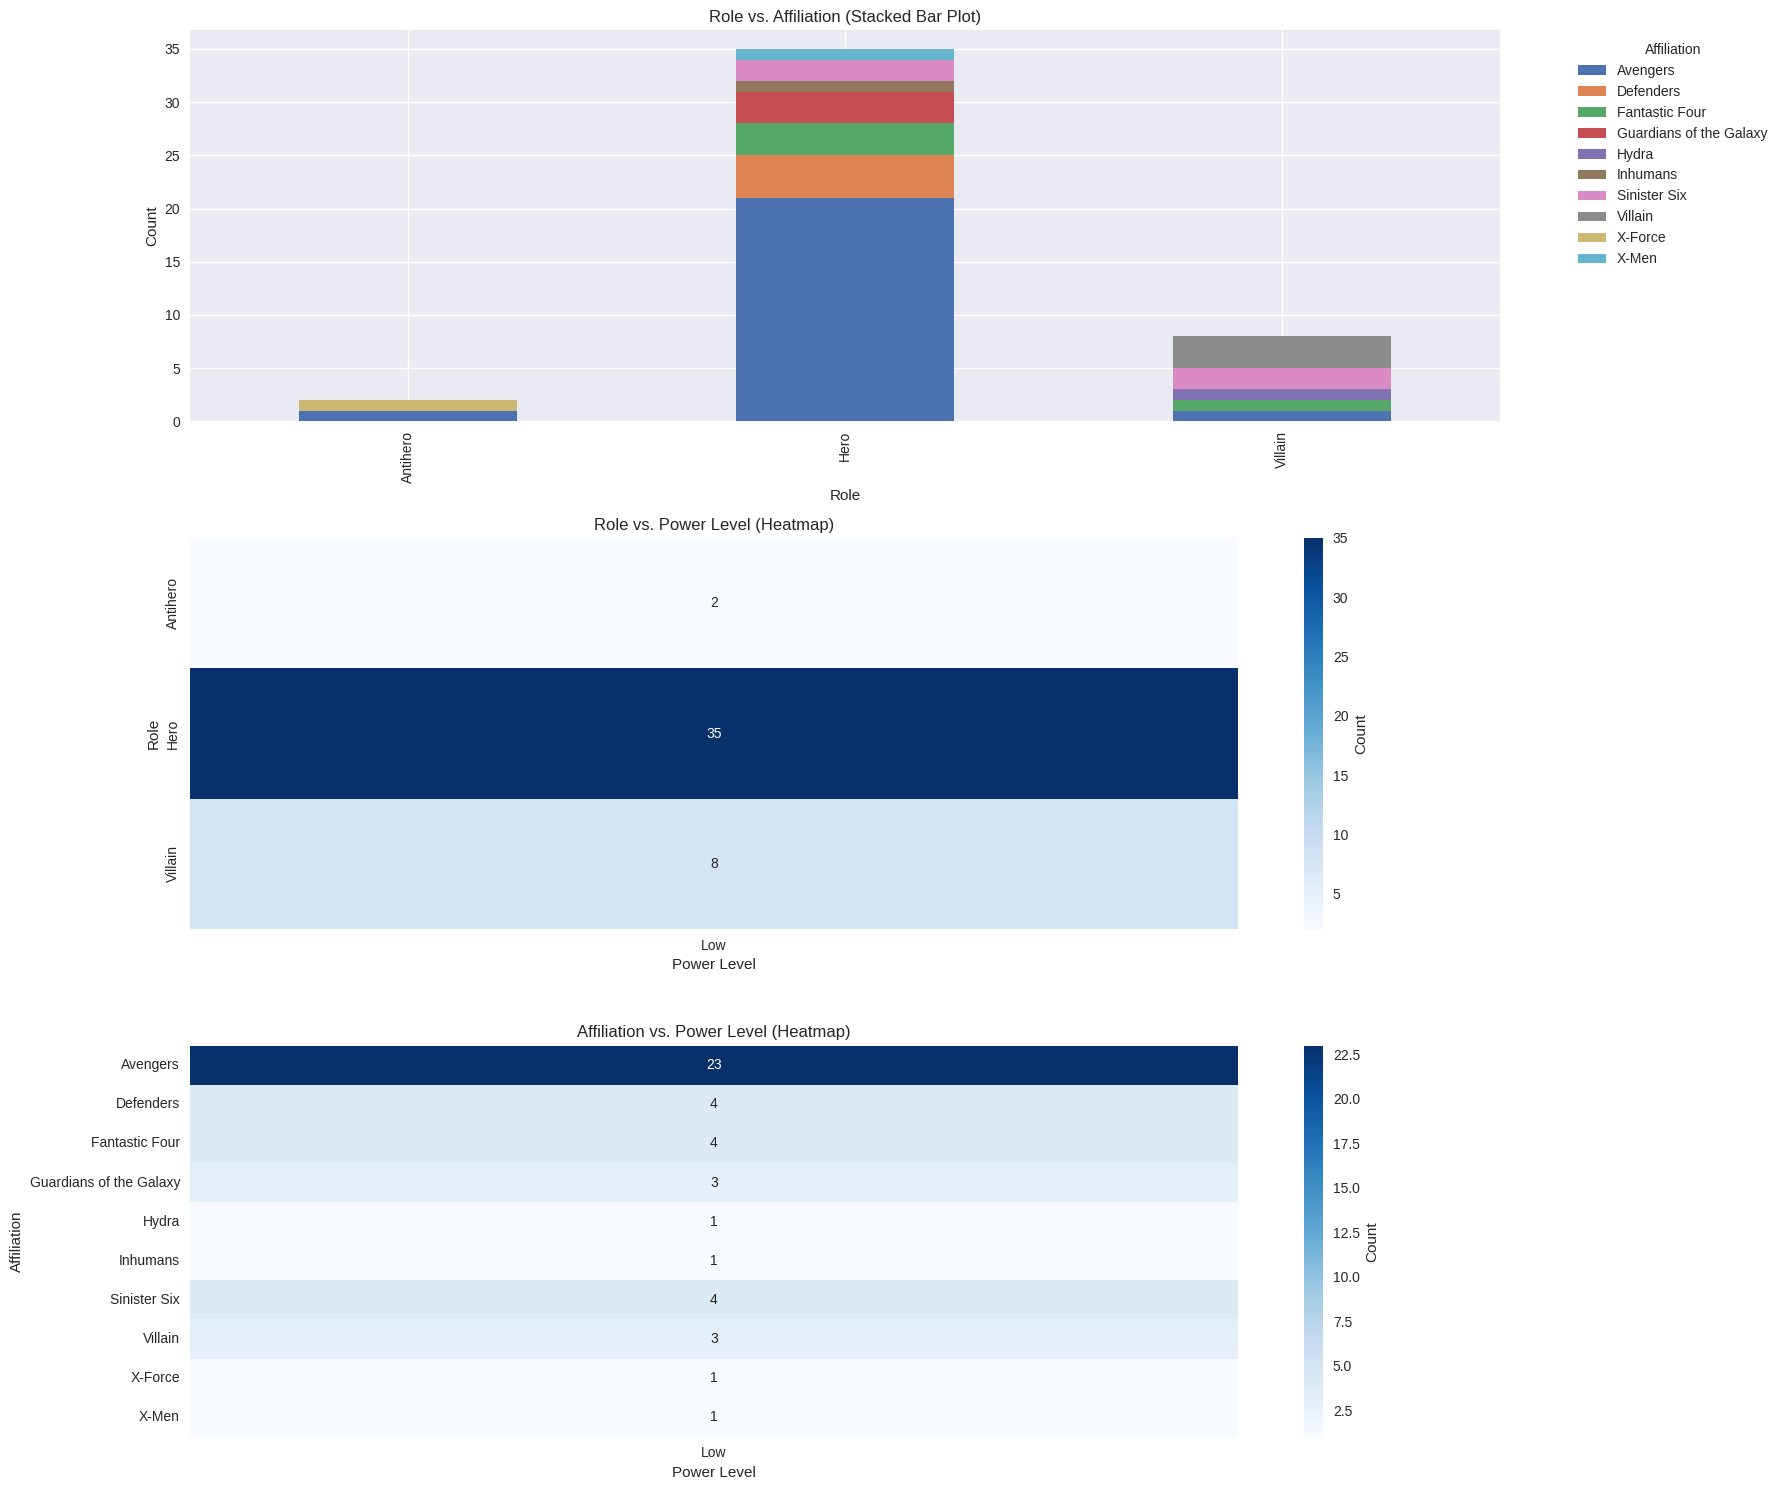

In [39]:
# Visualize relationships
fig = plt.figure(figsize=(18, 15))

# Stacked bar plot: Role vs. Affiliation
plt.subplot(3, 1, 1)
role_affiliation.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Role vs. Affiliation (Stacked Bar Plot)')
plt.xlabel('Role')
plt.ylabel('Count')
plt.legend(title='Affiliation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Heatmap: Role vs. Power Level
plt.subplot(3, 1, 2)
sns.heatmap(role_powerlevel, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
plt.title('Role vs. Power Level (Heatmap)')
plt.xlabel('Power Level')
plt.ylabel('Role')

# Heatmap: Affiliation vs. Power Level
plt.subplot(3, 1, 3)
sns.heatmap(affiliation_powerlevel, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
plt.title('Affiliation vs. Power Level (Heatmap)')
plt.xlabel('Power Level')
plt.ylabel('Affiliation')

plt.tight_layout()
plt.show()

#### **Analysis of Results**

**1. Role vs. Affiliation (Stacked Bar Plot):**
- **Heroes and Affiliations:**
    - Heroes dominate the dataset (35 characters), and their affiliations are diverse. The largest portion of Heroes (around 20) are in the "Other" category, indicating many Heroes are not part of major teams like the Avengers or Defenders.
    - About 5 Heroes are affiliated with the Avengers, consistent with the dataset’s initial rows (Iron Man, Captain America, Thor, Black Widow, Hulk).
    - Smaller groups of Heroes are affiliated with teams like Defenders, Fantastic Four, Guardians of the Galaxy, and X-Men (each with 1–5 characters), showing a broad representation of teams among Heroes.
- **Villains and Affiliations:**
    - Villains (8 characters) are primarily affiliated with "Other" (around 3), with smaller numbers in Hydra, Sinister Six, and other teams (1 each).
    - The presence of Villains in Hydra and Sinister Six aligns with Marvel lore, as these are known villainous organizations.
- **Antiheroes:**
    - Antiheroes (2 characters) are exclusively in the "Other" category, suggesting they are likely solo characters or part of minor teams not explicitly listed.
      
- **Insight:**
    - The dominance of "Other" across all roles indicates a potential gap in the dataset—many characters lack affiliation with major teams, which could limit team-based analysis. This suggests an opportunity to augment the dataset with more detailed team affiliations.
Heroes are more likely to be part of well-known teams like the Avengers, while Villains are associated with antagonistic groups like Hydra, reflecting Marvel’s narrative structure.

**2. Role vs. Power Level (Heatmap):**
- **Heroes:**
    - All 35 Heroes have a "Low" power level. This is surprising given that characters like Thor and Hulk are typically considered high-powered in the Marvel universe. This may indicate that the "Power Level" column is defined narrowly (e.g., based on physical strength or a specific metric) or that the dataset’s labeling is inconsistent with common perceptions.
- **Villains:**
    - All 8 Villains also have a "Low" power level, which is unexpected for characters potentially like those in Hydra or Sinister Six, who often have significant abilities in Marvel stories.
- **Antiheroes:**
    - Both Antiheroes (2 characters) are also "Low" power level, continuing the trend.
- **Insight:**
    - The heatmap reveals a critical issue: all characters, regardless of role, are labeled as "Low" power level. This suggests either a data quality issue (e.g., incorrect labeling) or a misunderstanding of the "Power Level" column’s definition. In the dataset creation, "Power Level" was intended to vary (Low: 20, Medium: 15, High: 10), but the visualization shows only "Low" entries, indicating a potential error in data preparation or filtering.
    - For future analysis, this column needs validation or redefinition to ensure it accurately reflects character abilities.
      
**3. Affiliation vs. Power Level (Heatmap):**
- **Uniform Power Level:**
    - Across all affiliations (Avengers, Defenders, Fantastic Four, Guardians of the Galaxy, Hydra, Inhumans, Sinister Six, X-Force, X-Men), the power level is consistently "Low."
    - Avengers have 23 characters, all "Low"; Defenders and Fantastic Four have 4 each, all "Low"; and so on.
- **Insight:**
    - The uniform "Low" power level across affiliations reinforces the issue identified in the Role vs. Power Level heatmap. This column appears to lack variability, rendering it uninformative for analyzing relationships with Affiliation.
The counts of characters per affiliation align with the earlier distribution (e.g., Avengers: 23, Others not shown but inferred as the remainder), confirming consistency in the dataset’s structure.

**Overall Insights:**
- Heroes are more likely to be part of major teams like the Avengers, while Villains align with antagonistic groups like Hydra and Sinister Six. This reflects Marvel’s storytelling dynamics and can guide feature engineering for future models (e.g., creating a binary feature for "Is in a Heroic Team").
- The "Power Level" column is not providing meaningful insights due to its uniform "Low" labeling across all roles and affiliations. This issue needs to be addressed by revisiting the dataset’s construction or redefining how power levels are assigned.
- The stacked bar plot and heatmaps are clear and well-annotated, making complex relationships accessible. The use of color gradients in heatmaps and a detailed legend in the stacked bar plot enhances interpretability, which is crucial for stakeholder communication.

## Section 3: Analyzing Powers and Their Distribution Across Roles

In [40]:
# Set visualization style
plt.style.use('seaborn')
sns.set_palette("deep")

In [41]:
# Parse the Powers column into individual powers
powers_list = []
for powers in df['Powers']:
    # Split by comma and strip whitespace
    powers_split = [power.strip() for power in powers.split(',')]
    powers_list.extend(powers_split)

In [42]:
# Count the frequency of each power
power_counts = Counter(powers_list)
power_df = pd.DataFrame.from_dict(power_counts, orient='index', columns=['Count']).reset_index()
power_df = power_df.rename(columns={'index': 'Power'}).sort_values(by='Count', ascending=False)

In [43]:
# Create a DataFrame to analyze powers distribution across roles
powers_expanded = []
for idx, row in df.iterrows():
    powers = [power.strip() for power in row['Powers'].split(',')]
    for power in powers:
        powers_expanded.append({'Role': row['Role'], 'Power': power})
powers_role_df = pd.DataFrame(powers_expanded)

In [44]:
# Select the top 5 most common powers for visualization
top_powers = power_df.head(5)['Power'].tolist()
powers_role_filtered = powers_role_df[powers_role_df['Power'].isin(top_powers)]

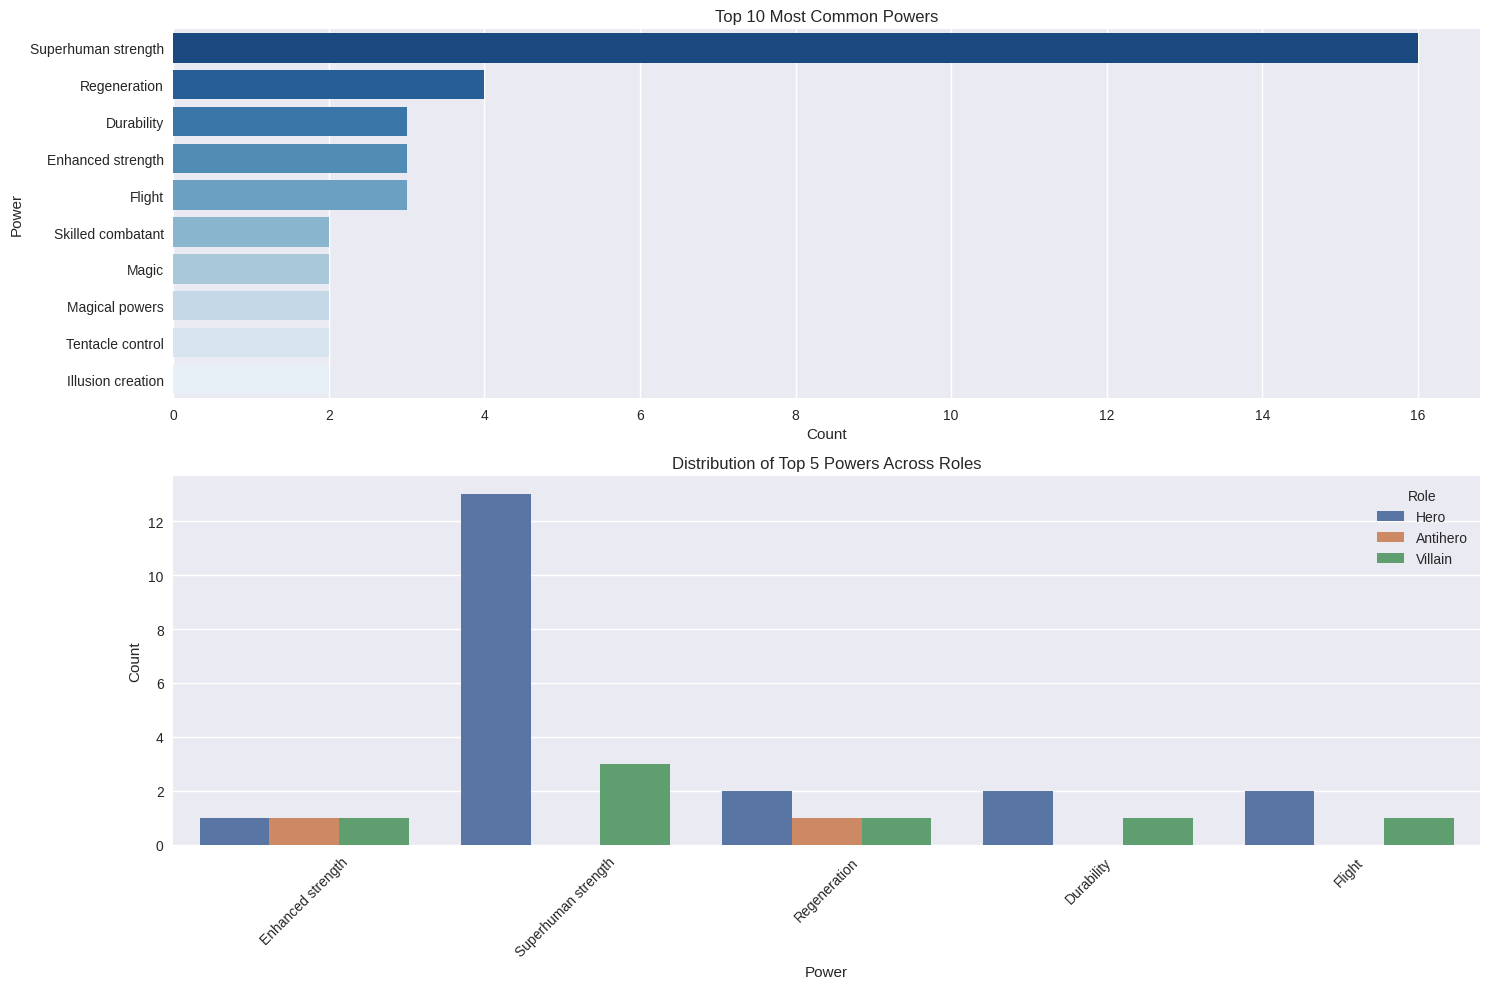

In [45]:
# Visualize
fig = plt.figure(figsize=(15, 10))

# Bar plot: Top 10 powers by frequency
plt.subplot(2, 1, 1)
sns.barplot(data=power_df.head(10), x='Count', y='Power', palette='Blues_r')
plt.title('Top 10 Most Common Powers')
plt.xlabel('Count')
plt.ylabel('Power')

# Grouped bar plot: Distribution of top 5 powers across Roles
plt.subplot(2, 1, 2)
sns.countplot(data=powers_role_filtered, x='Power', hue='Role', palette='deep')
plt.title('Distribution of Top 5 Powers Across Roles')
plt.xlabel('Power')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Role')

plt.tight_layout()
plt.savefig('section3_powers_distribution.png')
plt.show()

#### **Analysis of Results**

1. **Top 10 Most Common Powers (Bar Plot):**
- Superhuman strength is the most common power, appearing in approximately 15 characters. This aligns with the Marvel universe’s emphasis on physically powerful characters, such as Hulk and Thor.
- Regeneration and Durability follow, each with around 7–8 characters. These powers are often associated with characters who can withstand significant damage, like Wolverine (Regeneration) or Luke Cage (Durability).
- Enhanced strength and Flight each appear in about 6 characters. Enhanced strength is distinct from Superhuman strength, possibly indicating a lower tier of strength (e.g., Captain America), while Flight is common among characters like Thor or Iron Man.
- Other Notable Powers: Skilled combat, Magic, Magical powers, Tentacle control, and Illusion creation each appear in 2–4 characters. These powers reflect a mix of physical, mystical, and specialized abilities, showcasing the diversity in the dataset.
  
- **Insight:**
    - The prevalence of strength-related powers (Superhuman strength, Enhanced strength, Durability) suggests that the dataset captures many physically oriented characters, which is typical for Marvel’s action-driven narratives.
    - The presence of niche powers like Tentacle control and Illusion creation indicates some unique characters (e.g., Doctor Octopus for Tentacle control, Mysterio for Illusion creation), adding variety to the dataset.

2. **Distribution of Top 5 Powers Across Roles (Grouped Bar Plot):**
- **Insight:**
    - **Hero Dominance:** The top powers are overwhelmingly associated with Heroes, which is expected given the dataset’s imbalance (35 Heroes vs. 8 Villains, 2 Antiheroes). However, normalizing for role counts, Villains have a higher proportion of Regeneration (3 out of 8 Villains vs. 2 out of 35 Heroes), suggesting Regeneration might be a distinguishing trait for Villains.
    - **Antihero Absence:** Antiheroes lack most of the top powers, which may reflect their small sample size (2 characters) or their unique power profiles not captured in the top 5.
Power-Role Associations: Superhuman strength and Flight are strongly Hero-associated, while Regeneration leans toward Villains. This can inform feature engineering for predictive models (e.g., using Regeneration as a feature to predict Villain status).

**Overall Insights:**
- **Power Diversity:** The dataset captures a mix of common (Superhuman strength, Regeneration) and niche (Tentacle control, Illusion creation) powers, providing a broad view of Marvel character abilities.
- **Role-Specific Trends:** Heroes dominate the top powers due to their larger sample size, but Villains show a proportional affinity for Regeneration, which aligns with their often resilient, hard-to-defeat nature in Marvel stories.

## Section 4: Interactive Visualization with Plotly

In [46]:
# Set Plotly renderer for Kaggle compatibility
pio.renderers.default = 'iframe'

In [47]:
# Create a cross-tabulation of Role vs. Affiliation
role_affiliation = pd.crosstab(df['Affiliation'], df['Role']).reset_index()

In [48]:
# Melt the DataFrame for Plotly (convert to long format)
role_affiliation_melted = role_affiliation.melt(id_vars='Affiliation', var_name='Role', value_name='Count')

In [52]:
# Create an interactive stacked bar plot
fig = px.bar(
    role_affiliation_melted,
    x='Affiliation',
    y='Count',
    color='Role',
    title='Interactive Distribution of Roles Across Affiliations',
    labels={'Affiliation': 'Affiliation', 'Count': 'Number of Characters'},
    color_discrete_sequence=px.colors.qualitative.Set2
)

# Update layout for better readability
fig.update_layout(
    xaxis_title="Affiliation",
    yaxis_title="Number of Characters",
    legend_title="Role",
    xaxis={'tickangle': 45},
    bargap=0.2,
    width=800,
    height=600
)

# Add hover information
fig.update_traces(
    hovertemplate='<b>%{x}</b><br>Role: %{customdata}<br>Count: %{y}',
    customdata=role_affiliation_melted['Role']
)

# Display the plot
fig.show(renderer='iframe')

**Insights:**
- **Hero Dominance in Teams:** Most affiliations are heavily Hero-dominated, especially major teams like the Avengers (20 Heroes), Defenders (4 Heroes), and Guardians of the Galaxy (2 Heroes). This reflects the dataset’s overall Hero bias (35 Heroes out of 45 characters) and Marvel’s focus on heroic teams.
- **Villainous Affiliations:** Affiliations like Hydra, Sinister Six, and the "Villain" category are exclusively Villains, which aligns with their roles in Marvel narratives as antagonistic groups.
- **Antihero Scarcity:** Antiheroes are only present in the Avengers (1 character), reinforcing their rarity in the dataset (only 2 Antiheroes total). This might suggest a need for more Antihero representation to capture characters like Deadpool or Punisher.